In [210]:
from src.esn import ESN
from src.utils import config, helper
from src.conceptors import compute_conceptor, loading_ridge_report

In [211]:
import numpy as np
import matplotlib.pyplot as plt

In [212]:
prng = np.random.default_rng(1234)

In [213]:
esnConfig = config.ESNConfig(
    input_size=1,
    reservoir_size=100,
    output_size=1,
    feedback=False,
    spectral_radius=1.5,
    init_weights='normal',
    init_weights_b='normal',
    init_weights_in='normal',
    init_weights_density=0.2,
    init_weights_in_density=1.0,
    init_weights__args={'loc': 0., 'scale': 1.},
    init_weights_b__args={'loc': 0., 'scale': 0.2},
    init_weights_in__args={'loc': 0., 'scale': 1.5},
)

In [214]:
T_pattern = 2500
ut = [
    helper.n_periodic(4, T_pattern, np.random.default_rng(27)),
    helper.n_periodic(4, T_pattern, np.random.default_rng(42)),
    helper.n_sine(8.83, T_pattern, phase=0.25),
    helper.n_sine(9.83, T_pattern, phase=0.)
]

In [215]:
T_WASHOUT = 100
LOADING_REGULARIZER = 1e-3
APERTURE = 25.

In [216]:
esn = ESN(esnConfig, prng)

In [217]:
xt, yt = list(zip(*map(esn.harvest_states, ut)))
# concatenate patterns along time
X = helper.concatenate_patterns(xt, T_WASHOUT)
U = helper.concatenate_patterns(ut, T_WASHOUT)

In [218]:
Y_T = U.copy()
w_before_training = esn.w
esn.update_weights(X, U, Y_T, alpha=1e-3)

In [219]:
_, yt_trained = list(zip(*map(esn.harvest_states, ut)))

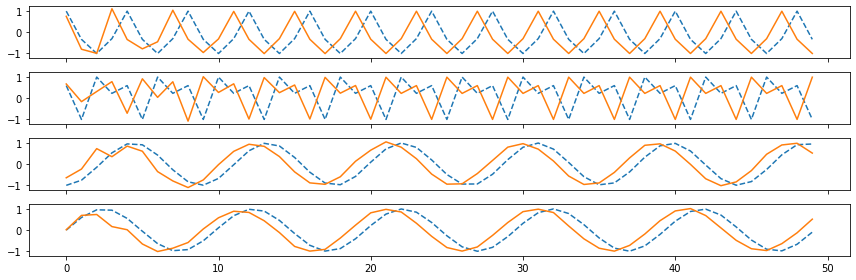

In [220]:
fig, ax = plt.subplots(len(ut), 1, figsize=(12, len(ut)), sharex=True, sharey=True)
for i in range(len(ut)):
    ax[i].plot(ut[i][:50], ls='--')
    ax[i].plot(yt_trained[i][:50])
plt.tight_layout()

In [221]:
X_ = helper.concatenate_patterns(xt, T_WASHOUT, shift=-1)
B = np.repeat(esn.b, X_.shape[0], axis=1).T

In [222]:
W_loaded = loading_ridge_report(X, X_, B, regularizer=LOADING_REGULARIZER)

In [223]:
w_before_loading = esn.w.copy()
esn.w = W_loaded.copy()

In [224]:
# ut_loaded_zero = np.zeros_like(U)
# xt_loaded_zero, yt_loaded_zero = esn.harvest_states(ut_loaded_zero)

In [225]:
# xt_loaded, yt_loaded = list(zip(*map(esn.harvest_states, ut)))

In [226]:
Ci = [
    compute_conceptor(xt_i[T_WASHOUT:, :], aperture=APERTURE)
    for xt_i in xt
]

In [227]:
ut_zero = np.zeros_like(ut[0])
x_init = prng.uniform(low=-1., high=1., size=(esn.reservoir_size, 1))
xt_conceptor, yt_conceptor = list(zip(*[
    esn.harvest_states(ut_zero.copy(), x_init=x_init.copy(), C=Ci[i])
    for i in range(len(ut))
]))

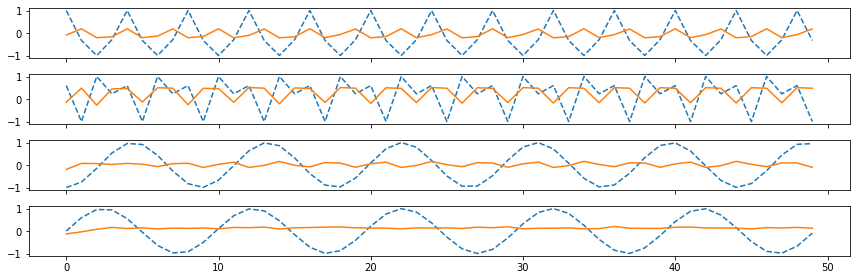

In [228]:
fig, ax = plt.subplots(len(ut), 1, figsize=(12, len(ut)), sharex=True, sharey=True)
for i in range(len(ut)):
    ax[i].plot(ut[i][:50], ls='--')
    ax[i].plot(yt_conceptor[i][:50])
plt.tight_layout()